In [2]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

31.511333333333333
29.857333333333333
28.666666666666668


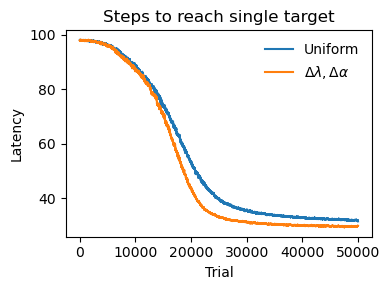

In [8]:

labels = ['Uniform', r'$\Delta\lambda, \Delta\alpha$', r'$\Delta\alpha, \Delta\sigma$']  # ,r'$\Delta\lambda, \Delta\alpha, \Delta\sigma$'
npcs = [2,4,8,16,32,64,128, 256, 512, 1024]
npcindex = 3
trials = 50000
window = 100
indexes = [[npcindex, 0,0,0], [npcindex, 1,1,0]]  # , [npcindex, 1,1,1]

f,ax = plt.subplots(1,1,figsize=(4,3))   
for i, index in enumerate(indexes):

    latency = 0
    for p in [0,10, 20]:
        [lats] = saveload(f'./compile_data/compile_lr_latencys_{p}_{p+10}',1,'load')

        latency +=np.mean(lats[npcindex, index[1], index[2], index[3]],axis=0)
        #ma = moving_average(latency, window)

    latency /= 3
    ma = moving_average(latency[:trials],window)
    ax.plot(ma, label=labels[i])
    print(ma[-1])
ax.set_xlabel('Trial')
ax.set_title('Steps to reach single target')
ax.set_ylabel('Latency')
#ax.set_xscale('log')
print(latency[-1])
ax.legend(frameon=False)
f.tight_layout()
f.savefig('./fig/uni_field_latency.svg')

In [6]:
# Trial for convergence vs N fields
threshold = 30

conv_epoch = np.zeros([len(indexes), lats.shape[0]])

for i, index in enumerate(indexes):
    for n,npc in enumerate(npcs):
        
        latency = 0
        for p in [0,10, 20]:
            [lats] = saveload(f'./compile_data/compile_lr_latencys_{p}_{p+10}',1,'load')

            latency += np.mean(lats[n, index[1], index[2], index[3]],axis=0)
            #ma = moving_average(latency, window)

        latency /= 3
        
        loss_vector = moving_average(latency,window)

        # Calculate convergence speed
        try:
            convergence_epoch = next(i for i, v in enumerate(loss_vector) if v < threshold)
        except StopIteration:
            convergence_epoch = len(loss_vector)
        
        conv_epoch[i, n] = convergence_epoch


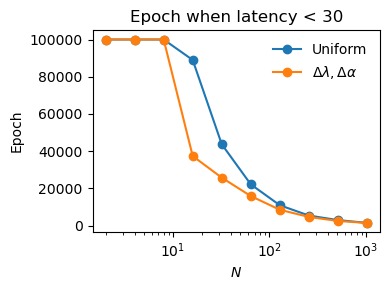

In [9]:
plt.figure(figsize=(4,3))
for i, index in enumerate(indexes):
    plt.plot(npcs, conv_epoch[i], label=labels[i], marker='o')

plt.xlabel('$N$')
plt.title('Epoch when latency < 30')
plt.ylabel('Epoch')
plt.xscale('log')
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('./fig/uni_field_npc_latency.svg')


(4, 2, 2, 3, 100000)


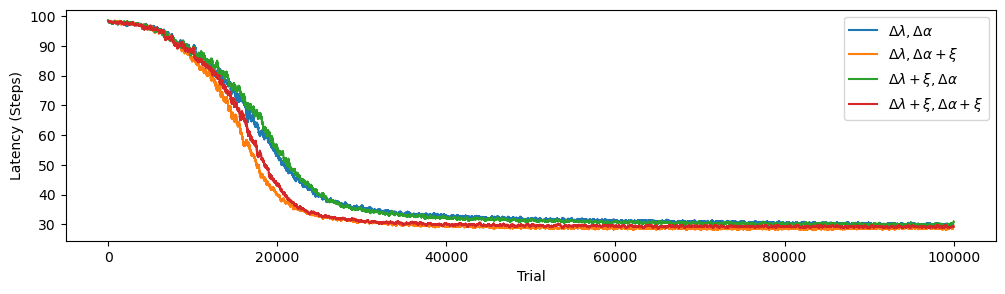

In [16]:
# alpha L1 norm vs trials with and without drift
[lats] = saveload('./compile_data/compile_drift_latencys',1,'load')
labels = [r'$\Delta\lambda, \Delta\alpha$', r'$\Delta\lambda , \Delta\alpha + \xi$', r'$\Delta\lambda + \xi, \Delta\alpha$', r'$\Delta\lambda + \xi, \Delta\alpha + \xi$']
npcindex = 0
indexes = [[npcindex, 0,0], [npcindex, 0,1], [npcindex, 1,0], [npcindex, 1,1]]
print(lats.shape)

plt.figure(figsize=(12,3))
for i, index in enumerate(indexes):
    latency = moving_average(np.mean(lats[npcindex, index[1], index[2]],axis=0),window_size=200)
    plt.plot(latency, label=labels[i])
plt.xlabel('Trial')
plt.ylabel('Latency (Steps)')
plt.legend()

In [14]:
noise = 0.00025
piname = '02'
train_episodes = 50000
llr = 0.0001
alr = 0.0001
slr = 0.0
npc = 64

# exptname = f'1D_td_online_{pcinit}_{noise}ns_{piname}p_{nact}a_{npc}n_{seed}s_{train_episodes}e_{goalsize}gs_{actor_eta}plr_{pc_eta}llr_{constant_eta}alr_{sigma_eta}slr'

# exptname = './data/1D_td_online_uni_0.00025ns_02p_2a_64n_2020s_50000e_0.025gs_0.0001plr_0.0025clr_0.0001llr_0.0001alr_0.0slr'
exptname = "./data/1D_td_online_0.01ba_0.00025ns_02p_64n_0.0001plr_0.00025clr_0.0001llr_0.0001alr_0.0slr_uni_2a_2020s_100000e_5rmax_0.025rsz"
[logparams, latencys, allcoords] = saveload(exptname, 1, 'load')


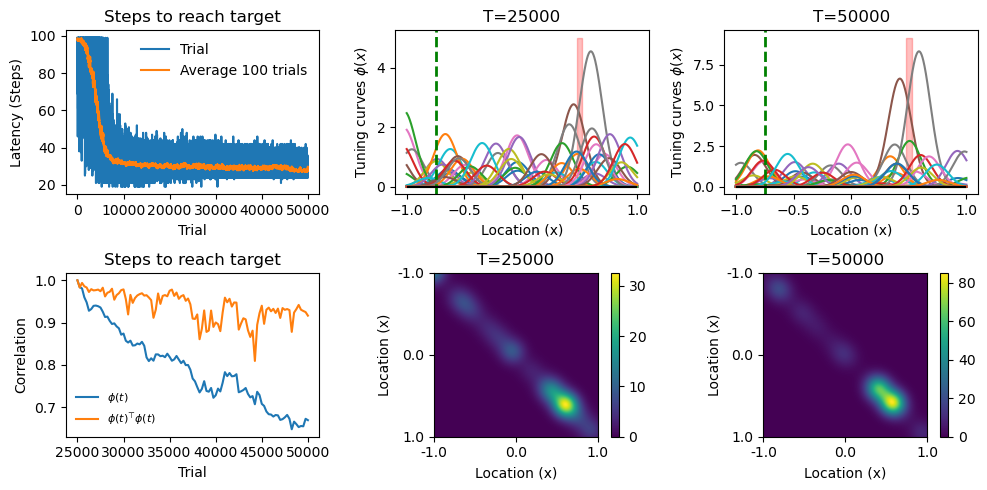

In [24]:
stable_perf = 25000
total_trials = 50000
window = 100

f,axs = plt.subplots(2,3,figsize=(10,5))
trials, pv_corr,rep_corr, startxcor, endxcor = get_pvcorr(logparams, stable_perf, total_trials, num=101)

plot_latency(latencys[:total_trials],ax=axs[0,0], window=window)
axs[0,0].set_title('')
axs[0,0].legend(['Trial', f'Average {window} trials'], frameon=False)
axs[0,0].set_title('Steps to reach target')

plot_pv_rep_corr(trials, pv_corr, rep_corr,ax=axs[1,0])
axs[1,0].legend(fontsize=8, frameon=False)
axs[1,0].set_title('Steps to reach target')

plot_pc(logparams, stable_perf,ax=axs[0,1], title=f'T={stable_perf}')
plot_pc(logparams, total_trials,ax=axs[0,2], title=f'T={total_trials}')

plot_rep_sim(startxcor, stable_perf, ax=axs[1,1])

plot_rep_sim(endxcor, total_trials, ax=axs[1,2])

f.tight_layout()
f.savefig('./fig/drift_lat_pc_pv_rep.svg')

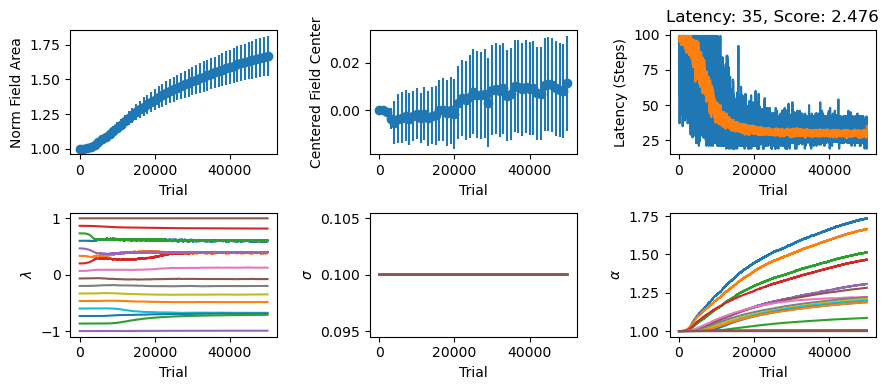

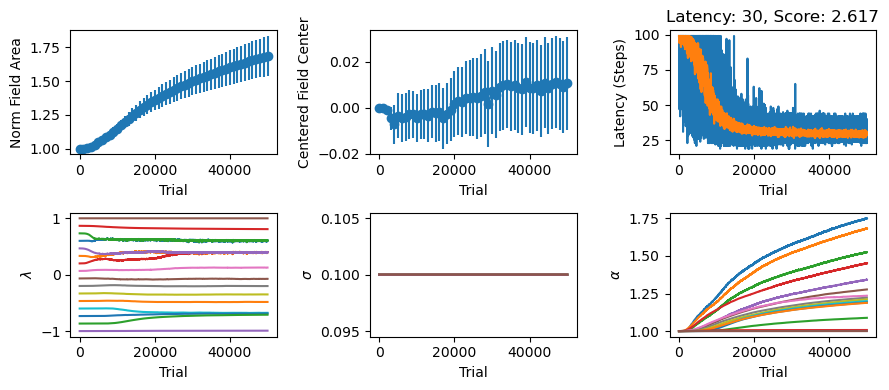

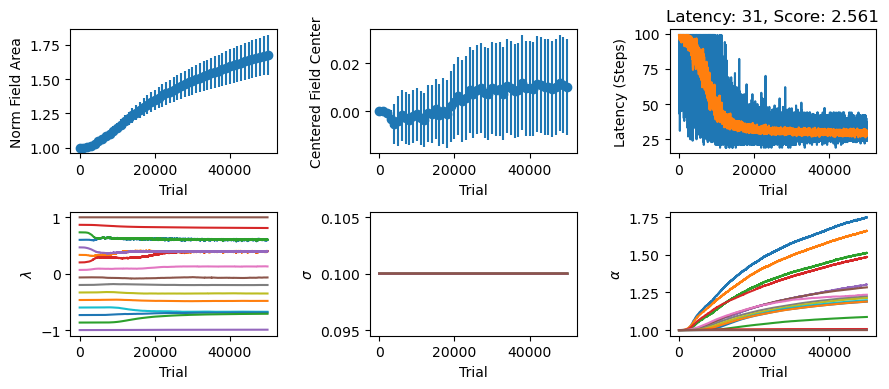

In [20]:
seeds = 3
total_trials = 50000

norm_lambdas = []
norm_areas = []
for seed in range(seeds):
    exptname = f"./data/1D_td_online_uni_0.0ns_p_2a_16n_{seed}s_50000e_0.025gs_0.0001plr_0.0025clr_0.0001llr_0.0001alr_0.0slr"
    [logparams, allcoords, latencys, losses] = saveload(exptname, 1, 'load')

    f,axs = plt.subplots(2,3,figsize=(9,4))

    plot_latency(latencys,ax=axs[0,2])

    norm_area = plot_field_area(logparams, np.linspace(0, total_trials, num=51, dtype=int), ax=axs[0,0])

    # change in field location
    norm_lambda = plot_field_center(logparams, np.linspace(0, total_trials, num=51, dtype=int),ax=axs[0,1])

    param_delta = get_param_changes(logparams, total_trials)
    plot_param_variance(param_delta, total_trials, 0,axs=axs[1], num=16)

    f.tight_layout()

    norm_areas.append(norm_area)
    norm_lambdas.append(norm_lambda)

norm_areas = np.array(norm_areas)
norm_lambdas = np.array(norm_lambdas)


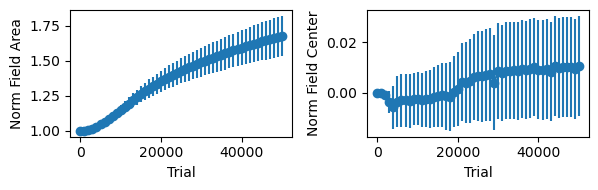

In [21]:
f,axs = plt.subplots(1,2,figsize=(6,2))
trials = np.linspace(0, total_trials, num=51, dtype=int)

norm_a = np.mean(norm_areas,axis=0)
norm_l = np.mean(norm_lambdas,axis=0)

ax = axs[0]
ax.errorbar(trials, np.mean(norm_a,axis=1), np.std(norm_a,axis=1)/np.sqrt(len(logparams[0][0])), marker='o')
ax.set_ylabel('Norm Field Area')
ax.set_xlabel('Trial')

ax = axs[1]
ax.errorbar(trials, np.mean(norm_l,axis=1), np.std(norm_l,axis=1)/np.sqrt(len(logparams[0][0])), marker='o')
ax.set_ylabel('Norm Field Center')
ax.set_xlabel('Trial')

f.tight_layout()

In [23]:
idx = np.argmax(np.mean(norm_l,axis=1)>0)
print(trials[idx])

19000


In [60]:
# continual learning
seeds = np.arange(2)
npcs = [16, 32, 64, 128,256, 512, 1024]
lats = np.zeros([4, len(seeds), len(npcs),  50000*5])

for n,npc in enumerate(npcs):
    for i,params in enumerate([[0.0, 0.0],[0.0, 0.00025], [0.01, 0.0], [0.01, 0.00025]]):
        balpha = params[0]
        noise = params[1]

        for s, seed in enumerate(seeds):
            exptname = f"./learn_data/learn_data/1D_td_online_uni_{noise}ns_{balpha}ba_02p_2a_{npc}n_{seed}s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr"
            print(exptname)

            [latencys] = saveload(exptname, 1, 'load')
            lats[i,s, n] = latencys
lats = np.mean(lats, axis=1)

./learn_data/learn_data/1D_td_online_uni_0.0ns_0.0ba_02p_2a_64n_0s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.0ns_0.0ba_02p_2a_64n_1s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.00025ns_0.0ba_02p_2a_64n_0s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.00025ns_0.0ba_02p_2a_64n_1s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.0ns_0.01ba_02p_2a_64n_0s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.0ns_0.01ba_02p_2a_64n_1s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.00025ns_0.01ba_02p_2a_64n_0s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr
./learn_data/learn_data/1D_td_online_uni_0.00025ns_0.01ba_02p_2a_64n_1s_50000e_0.025gs_0.0001plr_0.0001llr_0.0001alr_0.0slr


In [20]:
npcs = [16, 32, 64, 128,256, 512, 1024]
labels = ['No Drift', '$\\xi_t$', '$L_1^\\alpha$',  '$\\xi_t, L_1^\\alpha$']
seeds = 10
drift_params = np.zeros([2,2, 2])
for b, balpha in enumerate([0.0, 0.01]):
    for ns, noise in enumerate([0.0, 0.00025]):
        drift_params[b,ns] = np.array([balpha, noise])

print(drift_params.reshape(4,2))
[lats] = saveload('./learn_data/compile_drift_latencys', 1, 'load')
print(lats.shape)
lats = lats.reshape((len(npcs), 4, train_episodes*5))
print(lats.shape)

[[0.      0.     ]
 [0.      0.00025]
 [0.01    0.     ]
 [0.01    0.00025]]
(7, 2, 2, 250000)
(7, 4, 250000)


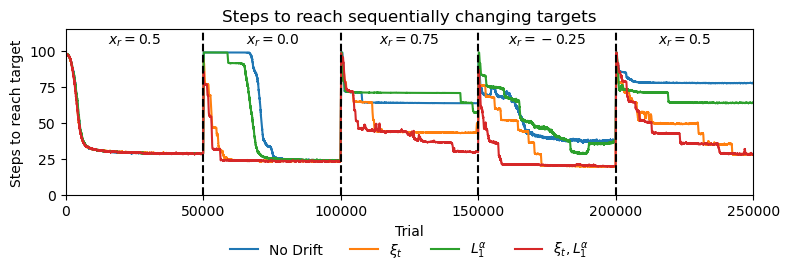

In [22]:
switch_interval = np.arange(start=50000, stop=50000*6, step=50000)
goalcoords = [0.5, 0.0, 0.75, -0.25, 0.5]
window = 200
npc_idx = 2

f,ax = plt.subplots(1,1,figsize=(8,3))
for i in range(4):
    ma = moving_average(lats[npc_idx, i], window_size=window)
    ax.plot(ma, label=labels[i])
ax.set_xlabel('Trial')
ax.set_ylabel('Steps to reach target')

for s, switch in enumerate(switch_interval[:-1]):
    ax.axvline(switch,color='k',linestyle='--')

for g in range(len(goalcoords)):
    ax.text(x=switch_interval[g]-25000,y=105, s=f"$x_r={goalcoords[g]}$", ha='center')
ax.set_ylim([0,115])
ax.set_xlim([0,250000])
ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set_title('Steps to reach sequentially changing targets')
f.tight_layout()
f.savefig('newlearn_drift_latency.svg')

In [79]:
# influence of N on latency
threshold = 35
conv_epoch = np.zeros([4,len(npcs), len(goalcoords)])

for n,npc in enumerate(npcs):
    for e in range(len(goalcoords)):
        end = switch_interval[e]
        start = end-50000

        for drift in range(4):
            latency = lats[n, drift, start:end]

            loss_vector = moving_average(latency,window)

            try:
                conv_epoch[drift,n, e] = next(i for i, v in enumerate(loss_vector) if v < threshold)
            except StopIteration:
                conv_epoch[drift,n, e] = len(loss_vector)


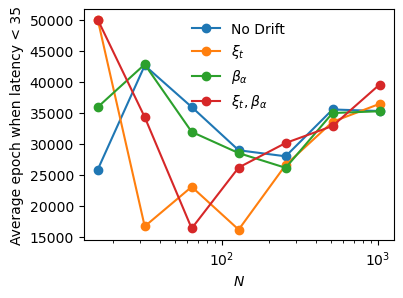

In [80]:
plt.figure(figsize=(4,3))

for drift in range(4):
    plt.plot(npcs, np.mean(conv_epoch[drift],axis=1), label=labels[drift], marker='o')

plt.xlabel('$N$')
plt.ylabel('Average epoch when latency < 35')
plt.xscale('log')
plt.legend(frameon=False)
           

In [43]:
[lats] = saveload("./data/compile_lr_optim_lat",1,"load")
print(lats.shape)
lrs = [0.0, 1e-6, 2.5e-5, 5e-5, 1e-4, 2.5e-4, 5e-4]
window = 100
threshold = 30
conv_epoch = np.zeros([7,7,7])
# find convergence
for i in range(7):
    for j in range(7):
        for k in range(7):
            latency = lats[i,j,k]

            loss_vector = moving_average(latency,window)

            # Calculate convergence speed
            try:
                convergence_epoch = next(i for i, v in enumerate(loss_vector) if v < threshold)
            except StopIteration:
                convergence_epoch = len(loss_vector)
            
            conv_epoch[i,j,k] = convergence_epoch /((loss_vector[-1]<threshold)+1e-6)


            

(7, 7, 7, 50000)


(8, 2, 2, 2, 50000)


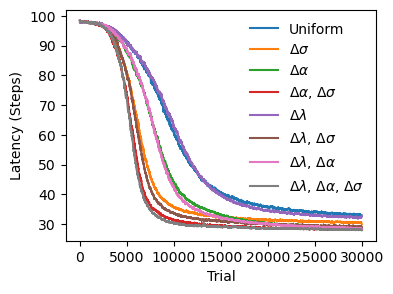

In [129]:
names = ["$\Delta\\lambda$", "$\Delta\\alpha$", "$\Delta\\sigma$"]
plt.figure(figsize=(4, 3))
npcs = [8,16,32,64,128, 256, 512, 1024]
window = 100
stable_perf = 30000
[lats] = saveload('./compile_data/compile_lr_latencys_310724', 1, 'load')
print(lats.shape)

lats = lats[1]
for l, lidx in enumerate([0, 1]):
    for a, aidx in enumerate([0, 1]):
        for s, sidx in enumerate([0, 1]):
            name = []
            if lidx > 0:
                name.append(names[0])
            if aidx > 0:
                name.append(names[1])
            if sidx > 0:
                name.append(names[2])
                
            label = ', '.join(name) if name else 'Uniform'
            latency = lats[lidx, aidx, sidx,:stable_perf]
            ma = moving_average(latency, window)
            if ma[-1] > 40:
                pass
            else:
                plt.plot(ma, label=label)

plt.xlabel('Trial')
plt.ylabel('Latency (Steps)')
plt.legend(frameon=False)
plt.savefig('latency_params.svg')

In [44]:
# Find the top 5 minimum convergence epochs
num = 10
flat_indices = np.argsort(conv_epoch, axis=None)[:num]
indices = np.unravel_index(flat_indices, conv_epoch.shape)

# Print the top 5 learning rates
for idx in range(num):
    min_index = (indices[0][idx], indices[1][idx], indices[2][idx])
    epoch = conv_epoch[min_index]
    min_index = (indices[0][idx], indices[1][idx], indices[2][idx], -1)
    lastlat = lats[min_index]
    llr, alr, slr = lrs[min_index[0]], lrs[min_index[1]], lrs[min_index[2]]
    print(f'Index: {min_index}, Epoch: {epoch}, LastLat: {lastlat},  llr: {llr}, alr: {alr}, slr: {slr}')

Index: (0, 6, 4, -1), Epoch: 13078.98692101308, LastLat: 27.333333333333332,  llr: 0.0, alr: 0.0005, slr: 0.0001
Index: (0, 6, 3, -1), Epoch: 13979.986020013981, LastLat: 27.333333333333332,  llr: 0.0, alr: 0.0005, slr: 5e-05
Index: (0, 5, 4, -1), Epoch: 14942.985057014945, LastLat: 30.0,  llr: 0.0, alr: 0.00025, slr: 0.0001
Index: (1, 6, 2, -1), Epoch: 15562.984437015564, LastLat: 26.0,  llr: 1e-06, alr: 0.0005, slr: 2.5e-05
Index: (0, 5, 3, -1), Epoch: 15696.984303015699, LastLat: 29.333333333333332,  llr: 0.0, alr: 0.00025, slr: 5e-05
Index: (0, 6, 2, -1), Epoch: 15892.984107015895, LastLat: 25.333333333333332,  llr: 0.0, alr: 0.0005, slr: 2.5e-05
Index: (1, 5, 3, -1), Epoch: 16139.983860016142, LastLat: 28.333333333333332,  llr: 1e-06, alr: 0.00025, slr: 5e-05
Index: (1, 4, 4, -1), Epoch: 17046.98295301705, LastLat: 28.0,  llr: 1e-06, alr: 0.0001, slr: 0.0001
Index: (0, 4, 4, -1), Epoch: 18112.981887018115, LastLat: 27.333333333333332,  llr: 0.0, alr: 0.0001, slr: 0.0001
Index: (1,

In [32]:
# Define the specific learning rates to check
target_lrs = [(1e-4, 1e-4, 1e-4), (1e-4, 1e-4, 0.0), (5e-4, 5e-4, 0.0),(1e-4, 1e-4, 0.0)]

# Find indices for each target configuration
for llr, alr, slr in target_lrs:
    i = lrs.index(llr)
    j = lrs.index(alr)
    k = lrs.index(slr)
    
    # Get the convergence epoch for these indices
    epoch = conv_epoch[i, j, k]
    print(f'llr: {llr}, alr: {alr}, slr: {slr} => Epoch: {epoch}')


llr: 0.0001, alr: 0.0001, slr: 0.0001 => Epoch: 50001.0
llr: 0.0001, alr: 0.0001, slr: 0.0 => Epoch: 32440.0
llr: 0.0005, alr: 0.0005, slr: 0.0 => Epoch: 50001.0
llr: 0.0001, alr: 0.0001, slr: 0.0 => Epoch: 32440.0


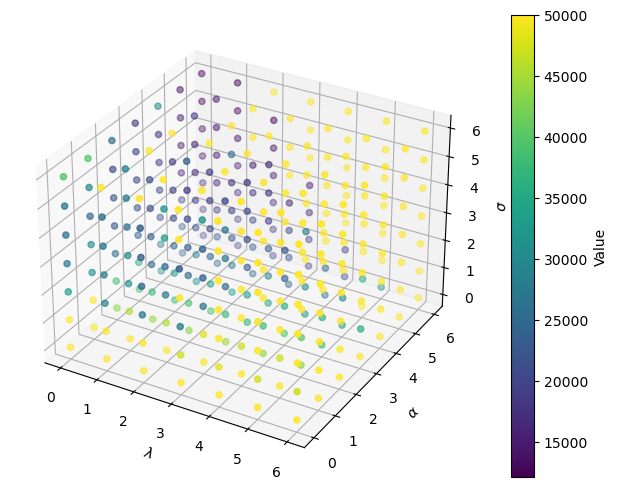

In [19]:
import matplotlib.pyplot as plt

# Generate coordinates for the matrix
x, y, z = np.indices(conv_epoch.shape)

# Flatten the arrays for plotting
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values_flat = conv_epoch.flatten()

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
sc = ax.scatter(x_flat, y_flat, z_flat, c=values_flat, cmap='viridis')

# Add a color bar
plt.colorbar(sc, ax=ax, label='Value')

# Set labels
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$\\alpha$')
ax.set_zlabel('$\\sigma$')

plt.show()


(8, 2, 2, 2, 50000)
Uniform 31.8
$\Delta\sigma$ 29.780666666666665
$\Delta\alpha$ 27.16033333333334
$\Delta\alpha$, $\Delta\sigma$ 27.807999999999996
$\Delta\lambda$ 30.089333333333332
$\Delta\lambda$, $\Delta\sigma$ 28.568333333333335
$\Delta\lambda$, $\Delta\alpha$ 27.897333333333336
$\Delta\lambda$, $\Delta\alpha$, $\Delta\sigma$ 30.169333333333334


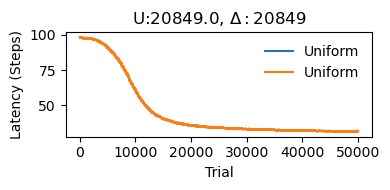

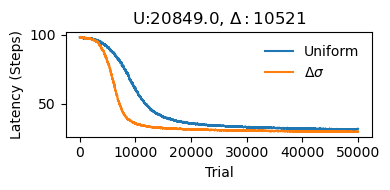

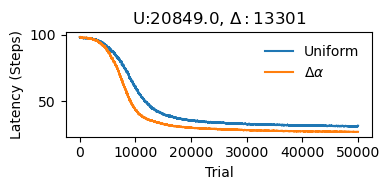

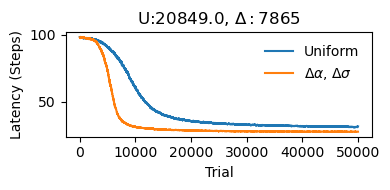

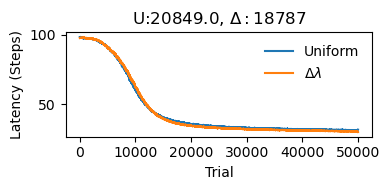

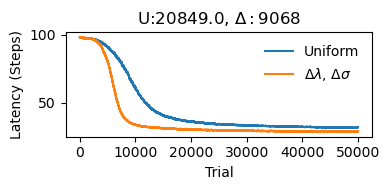

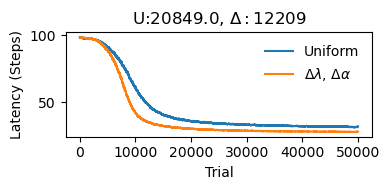

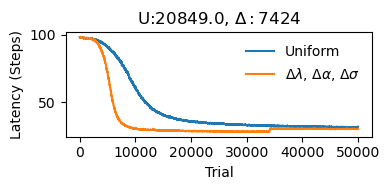

In [120]:
window_size = 100
npcs = [8,16,32,64,128, 256, 512, 1024]
threshold = 35

[lats] = saveload('./compile_data/compile_lr_latencys_310724', 1, 'load')
print(lats.shape)

conv_epoch = np.zeros([len(npcs),2,2,2])

names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for n,npc in enumerate(npcs):
    for l,llr in enumerate([0.0, 0.0001]):
        for a,alr in enumerate([0.0,0.0001]):
            for s, slr in enumerate([0.0,0.0001]):


                unima = moving_average(lats[n, 0, 0, 0], window_size)

                name_components = []
                if llr > 0:
                    name_components.append(names_dict['llr'])
                if alr > 0:
                    name_components.append(names_dict['alr'])
                if slr > 0:
                    name_components.append(names_dict['slr'])
                name = ', '.join(name_components) if name_components else 'Uniform'

                ma = moving_average(lats[n, l, a, s], window_size)

                try:
                    convergence_epoch = next(i for i, v in enumerate(ma) if v < threshold)
                except StopIteration:
                    convergence_epoch = len(ma)

                conv_epoch[n,l,a,s] = convergence_epoch

                if n == 1:
                    plt.figure(figsize=(4,2))
                    plt.plot(unima, label='Uniform')
                    plt.plot(ma, label=name)
                    plt.xlabel('Trial')
                    plt.ylabel('Latency (Steps)')
                    print(name, ma[-1])
                    plt.title(f'U:{conv_epoch[n,0,0,0]}, $\Delta: {convergence_epoch}$')
                    # plt.xscale('log')
                    plt.legend(frameon=False)
                    plt.tight_layout()


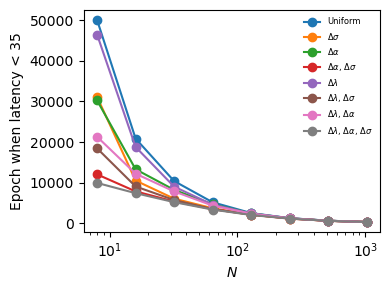

In [135]:
plt.figure(figsize=(4,3))


for l,llr in enumerate([0.0, 0.0001]):
    for a,alr in enumerate([0.0,0.0001]):
        for s, slr in enumerate([0.0,0.0001]):
            name_components = []
            if llr > 0:
                name_components.append(names_dict['llr'])
            if alr > 0:
                name_components.append(names_dict['alr'])
            if slr > 0:
                name_components.append(names_dict['slr'])
            name = ', '.join(name_components) if name_components else 'Uniform'
        
            plt.plot(npcs, conv_epoch[:,l,a,s], label=name, marker='o')

plt.xlabel('$N$')
plt.ylabel(f'Epoch when latency < {threshold}')
# plt.ylabel('Epoch')
plt.xscale('log')
# plt.yscale('log')
plt.legend(frameon=False, fontsize=6)

plt.tight_layout()
plt.savefig('./fig/uni_field_npc_latency.svg')


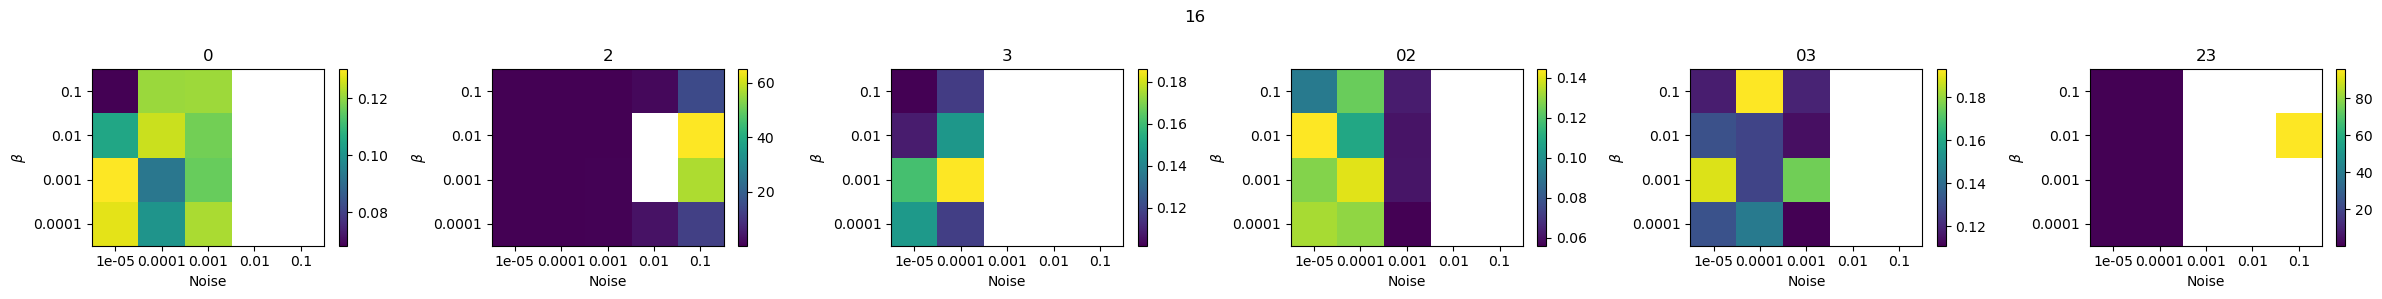

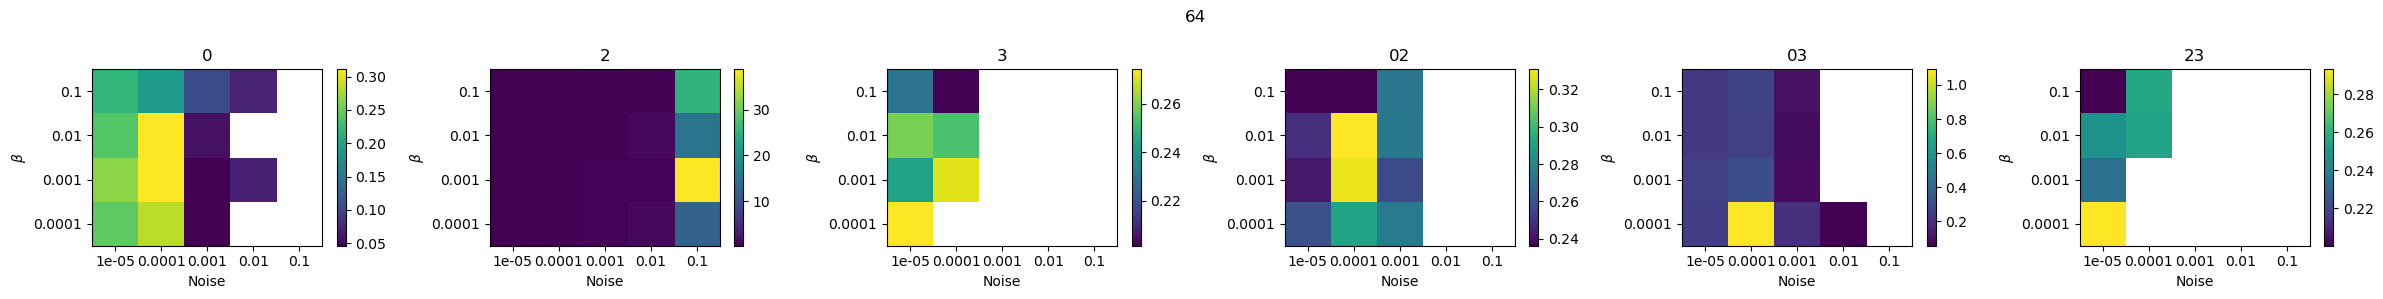

In [57]:
# plot drift vs ns vs balpha

train_episodes = 100000
pcinit = 'rand'
npcs = [16, 64]
balphas = [1e-4, 1e-3, 1e-2, 1e-1]
noises = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
pinames = [0, 2, 3, "02", "03", "23"]

datadir = './drift_data/'
scores = np.zeros([len(npcs), len(pinames),len(balphas),len(noises), train_episodes])
drifts = np.zeros_like(scores)

for n, npc in enumerate(npcs):
    [scores, drifts] = saveload(f'./compile_data/compile_drift_score_drift_{npc}n_{pcinit}pc',1, 'load')
    f,axs = plt.subplots(1,6,figsize=(24,3))
    f.suptitle(npc)

    for p, piname in enumerate(pinames):
        im = axs[p].imshow(drifts[p], aspect='auto', origin='lower')
        plt.colorbar(im,ax=axs[p])
        axs[p].set_xlabel('Noise')
        axs[p].set_ylabel('$\\beta$')
        # Set x-ticks and x-tick labels
        axs[p].set_xticks(np.arange(len(noises)))
        axs[p].set_xticklabels(noises)

        # Set y-ticks and y-tick labels
        axs[p].set_yticks(np.arange(len(balphas)))
        axs[p].set_yticklabels(balphas)

        axs[p].set_title(piname)
    f.tight_layout()

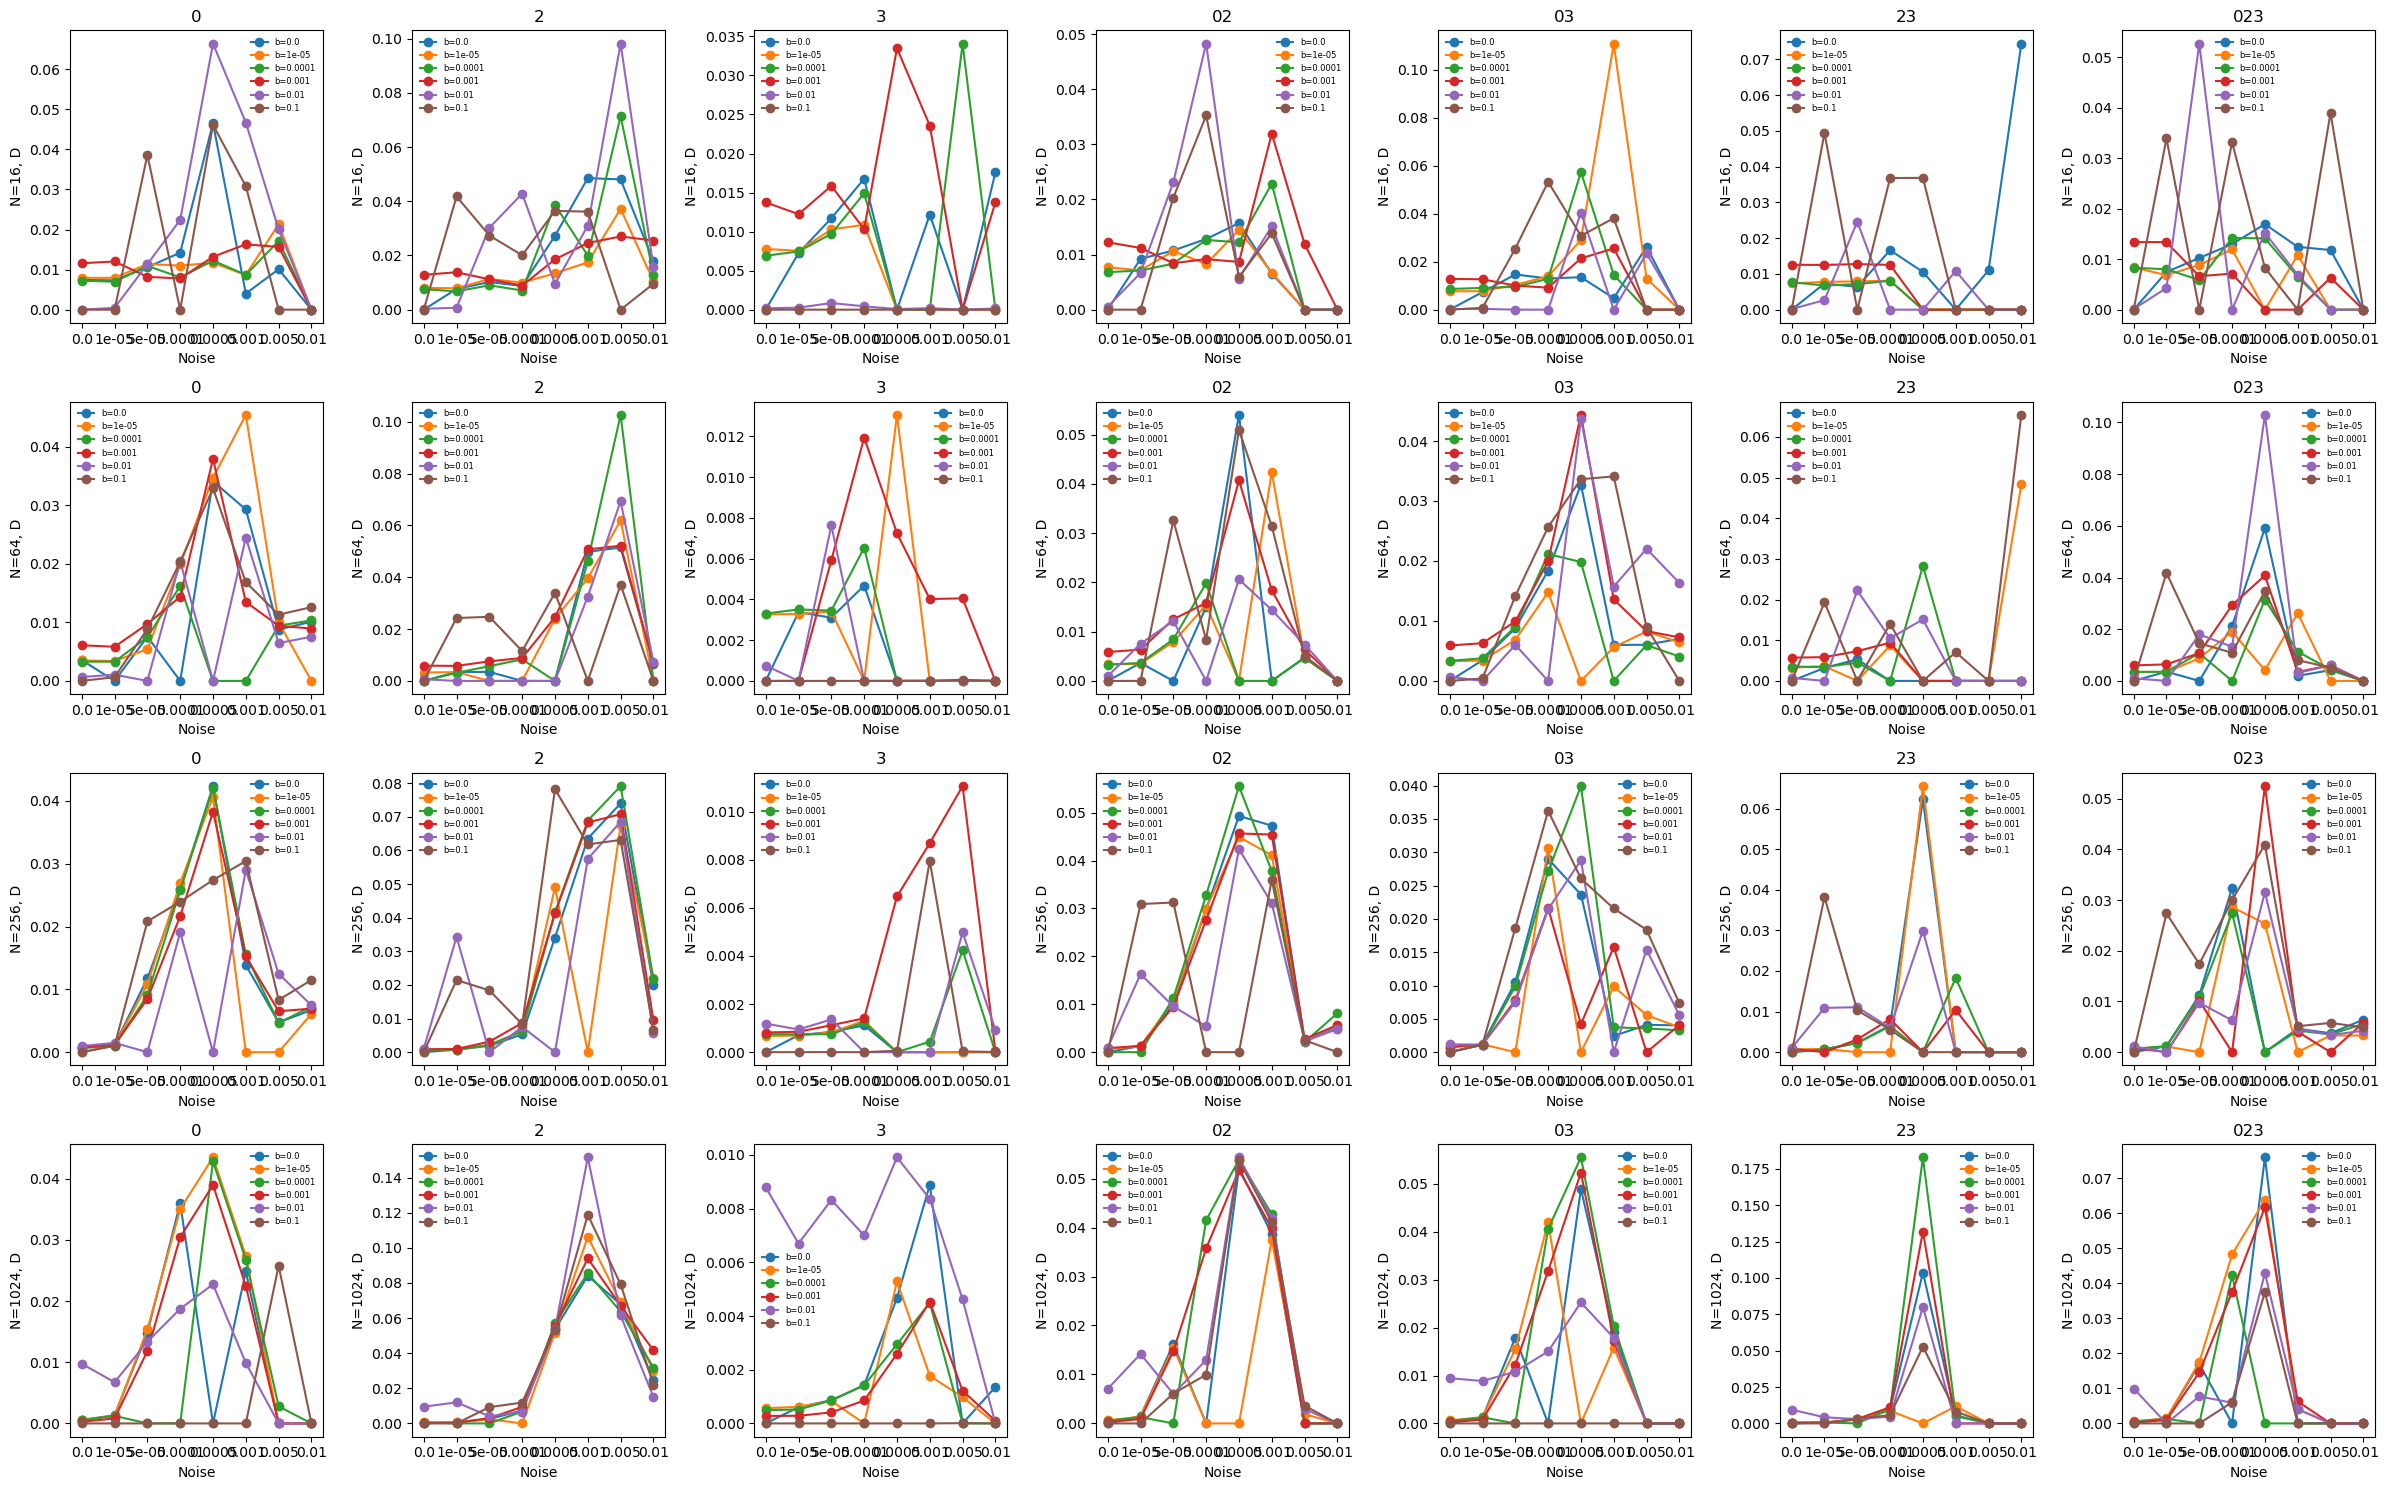

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file with proper error handling
csv_file_path = './compile_data/results_030824.csv'
df = pd.read_csv(csv_file_path, dtype={'piname': str})

# Fill NaN values with -1
df.fillna(-1, inplace=True)

# Ensure all necessary columns are of the correct type
df['npc'] = df['npc'].astype(int)
df['noise'] = df['noise'].astype(float)
df['balpha'] = df['balpha'].astype(float)
df['seed'] = df['seed'].astype(int)
df['score'] = df['score'].astype(float)
df['drift'] = df['drift'].astype(float)

# Parameters
train_episodes = 100000
pcinit = 'uni'
npcs = [16, 64, 256, 1024]
balphas = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  # , 1e-5, 1e-4, 1e-3, 1e-2, 1e-1
noises = [0.0, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
pinames = ["0", "2", "3", "02", "03", "23", "023"]
seed_count = 10  # Specify the number of seeds to use

# Initialize matrices to store scores and drifts
scores = np.zeros([len(npcs), len(pinames), len(balphas), len(noises), seed_count])
drifts = np.zeros_like(scores)

# Fill the matrices with values from the CSV file
for i, row in df.iterrows():
    npc = row['npc']
    noise = row['noise']
    balpha = row['balpha']
    piname = row['piname']
    seed = row['seed']
    score = row['score']
    drift = row['drift']

    if npc in npcs and noise in noises and balpha in balphas and piname in pinames and seed < seed_count:
        npc_idx = npcs.index(npc)
        noise_idx = noises.index(noise)
        balpha_idx = balphas.index(balpha)
        piname_idx = pinames.index(piname)

        scores[npc_idx, piname_idx, balpha_idx, noise_idx, seed] = score
        drifts[npc_idx, piname_idx, balpha_idx, noise_idx, seed] = drift

# Plotting
f, axs = plt.subplots(len(npcs), len(pinames), figsize=(24, 15))

for n, npc in enumerate(npcs):
    for p, piname in enumerate(pinames):
        # Compute the mean only for nonzero values
        score_masked = np.ma.masked_equal(scores[n, p, :, :, :seed_count], 0)
        drift_masked = np.ma.masked_equal(drifts[n, p, :, :, :seed_count], 0)
        
        score_matrix = np.mean(score_masked, axis=2).filled(0)
        drift_matrix = np.mean(drift_masked, axis=2).filled(0)


        for b, balpha in enumerate(balphas):
            axs[n, p].plot(np.maximum(drift_matrix[b], 0), label=f'b={balpha}', marker='o')

        axs[n, p].set_xlabel('Noise')
        axs[n, p].set_ylabel(f'N={npc}, D')

        # Set x-ticks and x-tick labels
        axs[n, p].set_xticks(np.arange(len(noises)))
        axs[n, p].set_xticklabels(noises)

        axs[n, p].set_title(piname)
        axs[n, p].legend(frameon=False, fontsize=6)

f.tight_layout()
plt.show()


[16, 128, 1024]


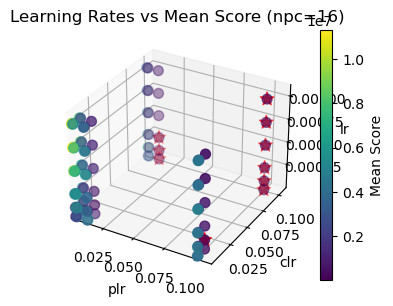

Top 3 combinations for npc=16:
         lr   clr   plr          score
31  0.00010  0.10  0.10   28684.335972
15  0.00000  0.10  0.10   40536.608251
30  0.00010  0.10  0.01  112049.463737
46  0.00025  0.10  0.01  155176.928729
47  0.00025  0.10  0.10  206352.792932
95  0.00100  0.10  0.10  211807.667030
14  0.00000  0.10  0.01  219936.092494
27  0.00010  0.01  0.10  221020.242569
63  0.00050  0.10  0.10  268318.118311
79  0.00075  0.10  0.10  352691.723723




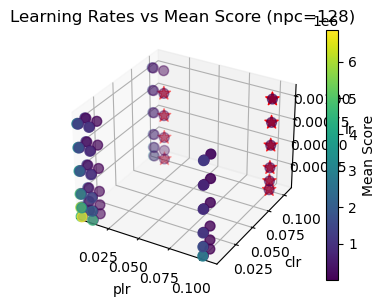

Top 3 combinations for npc=128:
         lr  clr   plr         score
15  0.00000  0.1  0.10   3473.280091
95  0.00100  0.1  0.10   3973.804620
31  0.00010  0.1  0.10   4454.584540
63  0.00050  0.1  0.10   4830.256067
79  0.00075  0.1  0.10   5299.568773
47  0.00025  0.1  0.10   5922.054083
78  0.00075  0.1  0.01   8882.535182
62  0.00050  0.1  0.01   9297.126162
14  0.00000  0.1  0.01  10139.458547
46  0.00025  0.1  0.01  10422.227858




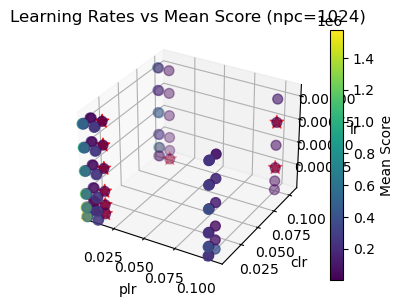

Top 3 combinations for npc=1024:
         lr   clr    plr         score
74  0.00075  0.01  0.010   4203.439120
42  0.00025  0.01  0.010   4365.967351
58  0.00050  0.01  0.010   4543.167241
26  0.00010  0.01  0.010   4678.591901
90  0.00100  0.01  0.010   5096.991958
10  0.00000  0.01  0.010   5111.397369
47  0.00025  0.10  0.100  11234.756568
14  0.00000  0.10  0.010  11994.341060
79  0.00075  0.10  0.100  12413.695592
25  0.00010  0.01  0.001  12508.972817




In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the CSV file
csv_file_path = './compile_data/results_lr_npc.csv'
df = pd.read_csv(csv_file_path)
topn = 10

# Function to assign a seed value between 0 and 29 for NaN
def assign_seed(x):
    if pd.isna(x):
        return np.random.randint(0, 30)
    return x

# Handle NaN values in the seed column
df['seed'] = df['seed'].apply(assign_seed)


# Ensure all necessary columns are of the correct type
df['npc'] = df['npc'].astype(int)
df['lr'] = df['lr'].astype(float)
df['clr'] = df['clr'].astype(float)
df['plr'] = df['plr'].astype(float)
df['seed'] = df['seed'].astype(int)
df['score'] = df['score'].astype(float)

# Get unique npc values
npcs = [16, 128, 1024]
print(npcs)

for npc in npcs:
    # Filter data for the current npc
    npc_data = df[df['npc'] == npc]

    # Group by lr, clr, and plr, and calculate mean score
    grouped_data = npc_data.groupby(['lr', 'clr', 'plr'])['score'].mean().reset_index()

    # Sort the data by score and get the top 3 combinations
    top_3 = grouped_data.sort_values('score').head(topn)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111, projection='3d')

    # Plot all points
    sc = ax.scatter(grouped_data['plr'], grouped_data['clr'], grouped_data['lr'], 
                    c=grouped_data['score'], cmap='viridis', s=50)

    # Highlight top 3 points
    ax.scatter(top_3['plr'], top_3['clr'], top_3['lr'], 
               c='red', s=100, marker='*')

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Mean Score')

    # Set labels
    ax.set_xlabel('plr')
    ax.set_ylabel('clr')
    ax.set_zlabel('lr')

    # Set scales
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_zscale('linear')  # symlog allows for zero values

    # Set axis limits slightly larger than the data range
    ax.set_xlim(grouped_data['plr'].min() * 0.9, grouped_data['plr'].max() * 1.1)
    ax.set_ylim(grouped_data['clr'].min() * 0.9, grouped_data['clr'].max() * 1.1)
    ax.set_zlim(max(grouped_data['lr'].min() * 0.9, 1e-5), grouped_data['lr'].max() * 1.1)

    ax.set_title(f'Learning Rates vs Mean Score (npc={npc})')

    # Add text labels for top 3 points
    # for idx, row in top_3.iterrows():
    #     ax.text(row['plr'], row['clr'], row['lr'], 
    #             f"({row['plr']:.1e}, {row['clr']:.1e}, {row['lr']:.1e})\nScore: {row['score']:.2f}", 
    #             fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print top 3 combinations
    print(f"Top 3 combinations for npc={npc}:")
    print(top_3)
    print("\n")

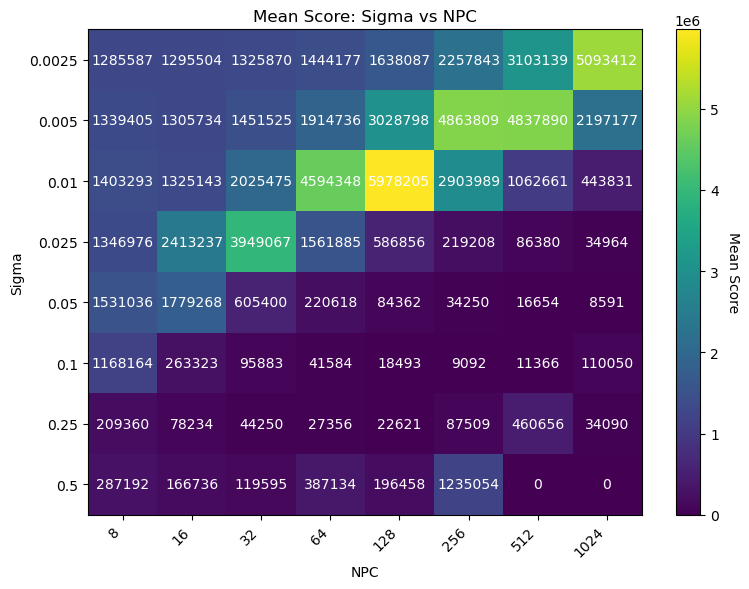

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = './compile_data/results_npc_sigma.csv'
df = pd.read_csv(csv_file_path)

# Get unique values for npc and sigma
npc_values = sorted(df['npc'].unique())
sigma_values = sorted(df['sigma'].unique())

# Create a 2D array to store the mean scores
mean_scores = np.zeros((len(sigma_values), len(npc_values)))

# Calculate mean scores for each combination of npc and sigma
for i, sigma in enumerate(sigma_values):
    for j, npc in enumerate(npc_values):
        subset = df[(df['sigma'] == sigma) & (df['npc'] == npc)]
        mean_scores[i, j] = subset['score'].mean()

# Create the plot
plt.figure(figsize=(8, 6))
im = plt.imshow(mean_scores, cmap='viridis', aspect='auto', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Mean Score', rotation=270, labelpad=15)

# Set tick labels
plt.xticks(range(len(npc_values)), npc_values, rotation=45, ha='right')
plt.yticks(range(len(sigma_values)), sigma_values)

plt.title('Mean Score: Sigma vs NPC')
plt.xlabel('NPC')
plt.ylabel('Sigma')

# Add text annotations
for i in range(len(sigma_values)):
    for j in range(len(npc_values)):
        text = plt.text(j, i, f'{mean_scores[i, j]:.0f}',
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.show()

# Optionally, save the figure
# plt.savefig('npc_sigma_imshow.png', dpi=300, bbox_inches='tight')

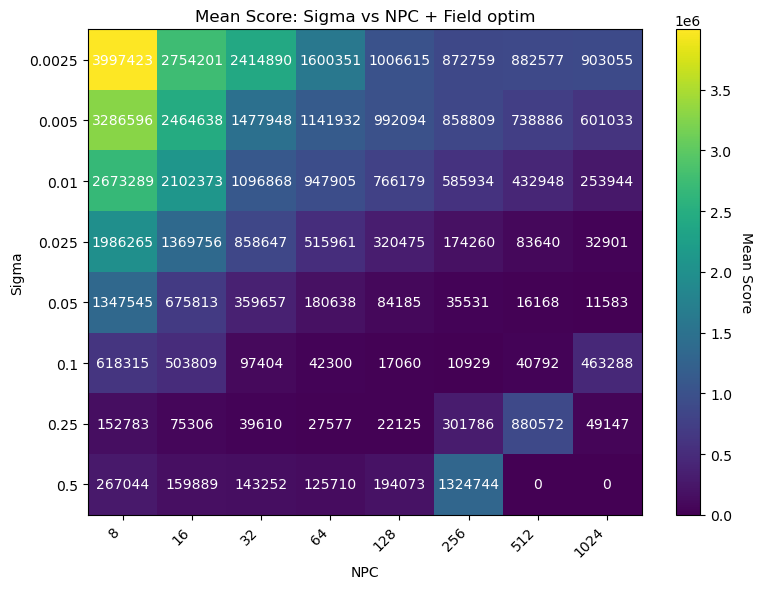

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = './compile_data/results_npc_sigma_field.csv'
df = pd.read_csv(csv_file_path)

# Get unique values for npc and sigma
npc_values = sorted(df['npc'].unique())
sigma_values = sorted(df['sigma'].unique())

# Create a 2D array to store the mean scores
mean_scores = np.zeros((len(sigma_values), len(npc_values)))

# Calculate mean scores for each combination of npc and sigma
for i, sigma in enumerate(sigma_values):
    for j, npc in enumerate(npc_values):
        subset = df[(df['sigma'] == sigma) & (df['npc'] == npc)]
        mean_scores[i, j] = subset['score'].mean()

# Create the plot
plt.figure(figsize=(8, 6))
im = plt.imshow(mean_scores, cmap='viridis', aspect='auto', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Mean Score', rotation=270, labelpad=15)

# Set tick labels
plt.xticks(range(len(npc_values)), npc_values, rotation=45, ha='right')
plt.yticks(range(len(sigma_values)), sigma_values)

plt.title('Mean Score: Sigma vs NPC + Field optim')
plt.xlabel('NPC')
plt.ylabel('Sigma')

# Add text annotations
for i in range(len(sigma_values)):
    for j in range(len(npc_values)):
        text = plt.text(j, i, f'{mean_scores[i, j]:.0f}',
                        ha="center", va="center", color="w")

plt.tight_layout()
plt.show()

# Optionally, save the figure
# plt.savefig('npc_sigma_imshow.png', dpi=300, bbox_inches='tight')

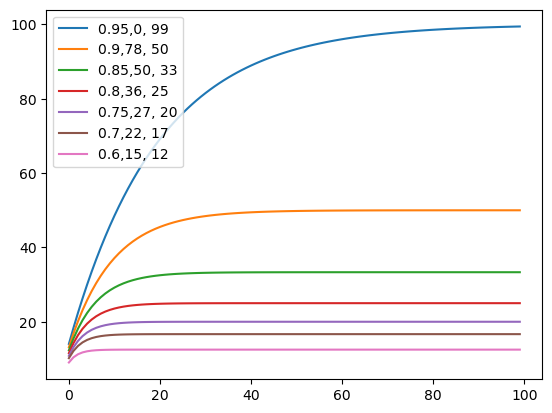

In [217]:
gammas = [0.95, 0.9,0.85,0.8,0.75,0.7,0.6]
tmax = 100
allG = np.zeros([len(gammas), tmax])
plt.figure()
for g, gamma in enumerate(gammas):
    for l in range(tmax):
        r = [0]*l
        r += [1,1,1,1,1]
        G = get_discounted_rewards(r, gamma)
        allG[g, l] = np.sum(G)
        idx =  np.argmax(np.diff(allG[g])<0.001)
        maxg = allG[g,-1]

    plt.plot(allG[g],label=f'{gamma},{idx}, {maxg:.0f}')

plt.legend()


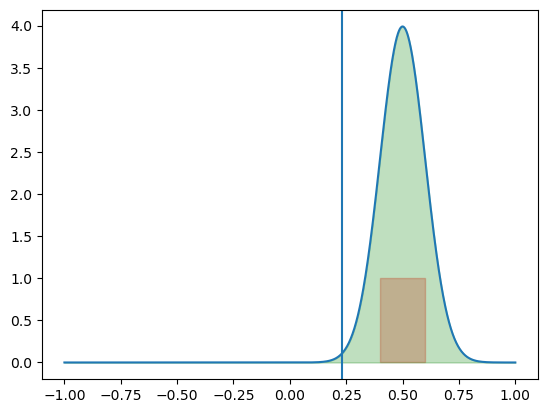

In [8]:
def reward_func(x, rcent, rsz):
    return 1/np.sqrt(2*np.pi*rsz**2) * np.exp(-0.5*((x - rcent)/rsz)**2)

rcent = 0.5
rsz = 0.1
goalsize = 0.1
x = np.linspace(-1,1,1001)
rx = reward_func(x, rcent, rsz)

plt.figure()
plt.fill_betweenx(np.linspace(0,1), rcent-goalsize, rcent+goalsize, color='r', alpha=0.25)
plt.plot(x,rx)
plt.axvline(x[np.argmax(rx>1e-1)])

plt.fill_between(x, rx, color='green', alpha=0.25)

0.07200000000000006